In [295]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as signal
import altair as alt

from pathlib import Path
from operator import and_
from functools import reduce
from itertools import chain, groupby, product, accumulate
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

alt.data_transformers.enable('default', max_rows=None)
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 10.8 ms


## Read Data

In [2]:
cols_names = [
    'acceleration, chest (X axis)',
    'acceleration, chest (Y axis)',
    'acceleration, chest (Z axis)',
    'ECG-1',
    'ECG-2',
    'acceleration, left-ankle (X axis)',
    'acceleration, left-ankle (Y axis)',
    'acceleration, left-ankle (Z axis)',
    'gyro, left-ankle (X axis)',
    'gyro, left-ankle (Y axis)',
    'gyro, left-ankle (Z axis)',
    'magnetometer, left-ankle (X axis)',
    'magnetometer, left-ankle (Y axis)',
    'magnetometer, left-ankle (Z axis)',
    'acceleration, right-lower-arm (X axis)',
    'acceleration, right-lower-arm (Y axis)',
    'acceleration, right-lower-arm (Z axis)',
    'gyro, right-lower-arm (X axis)',
    'gyro, right-lower-arm (Y axis)',
    'gyro, right-lower-arm (Z axis)',
    'magnetometer, right-lower-arm (X axis)',
    'magnetometer, right-lower-arm (Y axis)',
    'magnetometer, right-lower-arm (Z axis)',
    'activity'
]

time: 334 µs


In [3]:
activities_names = np.array([
    'N/A',
    'Standing still',
    'Sitting and relaxing',
    'Lying down',
    'Walking',
    'Climbing stairs',
    'Waist bends forward',
    'Frontal elevation of arms',
    'Knees bending (crouching)',
    'Cycling',
    'Jogging',
    'Running',
    'Jump front & back',
])

time: 317 µs


In [4]:
fs = 50

time: 431 µs


In [5]:
partial_dfs = []
for i in range(1, 11):
    partial_df = pd.read_table(Path('data')/ ('mHealth_subject' + str(i) + '.log'), header=None, names=cols_names)
    partial_df['timepoint'] =  np.arange(1/fs*len(partial_df), step=1/fs)[:len(partial_df)]
    partial_df['subject'] = i
    partial_dfs.append(partial_df)
    
df = pd.concat(partial_dfs)

time: 3.76 s


## Data Exploration

In [6]:
df.head()

,"acceleration, chest (X axis)","acceleration, chest (Y axis)","acceleration, chest (Z axis)",ECG-1,ECG-2,"acceleration, left-ankle (X axis)","acceleration, left-ankle (Y axis)","acceleration, left-ankle (Z axis)","gyro, left-ankle (X axis)","gyro, left-ankle (Y axis)",...,"acceleration, right-lower-arm (Z axis)","gyro, right-lower-arm (X axis)","gyro, right-lower-arm (Y axis)","gyro, right-lower-arm (Z axis)","magnetometer, right-lower-arm (X axis)","magnetometer, right-lower-arm (Y axis)","magnetometer, right-lower-arm (Z axis)",activity,timepoint,subject
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,0.187760,-0.44902,-1.0103,0.034483,-2.35000,-1.610200,-0.030899,0,0.00,1
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0,0.02,1
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0,0.04,1
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0,0.06,1
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0,0.08,1


time: 27.6 ms


In [7]:
df['activity'] = activities_names[df['activity']]

time: 250 ms


In [8]:
def get_activity_intervals_df(df):
    activity_intervals = []
    for i in df.groupby('subject'):
        prev = None
        timepoints = []
        activities = []

        for ind, val in enumerate(i[1]['activity']):
            if val != prev:
                prev = val
                timepoints.append(df.iloc[ind]['timepoint'])
                activities.append(val)
        timepoints.append(i[1].iloc[-1]['timepoint'])

        activity_df = pd.DataFrame({
            "start": pd.to_datetime(timepoints[:-1], unit='s'), 
            "end": pd.to_datetime(timepoints[1:], unit='s'), 
            'activity': activities,
            'subject': i[0]
        })
        activity_df['length'] = (activity_df['end'] - activity_df['start'])/ np.timedelta64(1, 's') 
        activity_intervals.append(activity_df)
    return pd.concat(activity_intervals)

time: 632 µs


In [9]:
activity_length_df = get_activity_intervals_df(df)

time: 622 ms


In [313]:
alt.Chart(activity_length_df).mark_rule().encode(
    y = alt.Y('activity:N'),
    x = alt.X('start:T', axis=alt.Axis(title='time, mm:ss', format =('%M:%S'))),
    x2 = alt.X2('end:T')
).properties(
    width = 700/2,
    height= 300
).facet(
    facet='subject:Q', 
    columns=2
)

alt.FacetChart(...)

time: 26.7 ms


We can see, that even though we nearly 1 hour of recording, we have nearly 12 minutes of usefull signals

In [107]:
alt.Chart(activity_length_df[activity_length_df['activity'] != activities_names[0]]).encode(
    x = 'length:Q',
    y = alt.Y('activity:N', title='length, s'),
).mark_bar().facet(facet='subject:N', columns=2)

alt.FacetChart(...)

time: 22.6 ms


Jump front & back is much shorter, then previous ones (20s vs 1m), so I decided to drop it. Also, subject #7 has much shorter Climbing stairs activity (only 15 seconds), so we can drop it to use larger window size.

In [12]:
def get_signal(subject, activity):
    def get_interval():
        tmp_df = activity_length_df[activity_length_df['subject'] == subject]
        res = tmp_df[tmp_df['activity'] == activity]
        return res['start'].values[0], res['end'].values[0]
    
    st, end = get_interval()
    to_seconds = lambda x: x.astype('float')/10**9
    get_index = lambda x: np.argmin(np.abs(df['timepoint'].values - x))
    st, end = to_seconds(st), to_seconds(end)
    
    return df.iloc[get_index(st): get_index(end)]

time: 621 µs


## Data Preprocessing

In [194]:
window_length = 30
used_signals = ['ECG-1', 'ECG-2', 'timepoint']
used_signals += [
    'acceleration, right-lower-arm (X axis)',
    'acceleration, right-lower-arm (Y axis)',
    'acceleration, right-lower-arm (Z axis)',
]
used_signals += ['subject']
activity_to_signals = defaultdict(list)
# df
# activity_length_df
for activity in activities_names:
    if activity in ['N/A']:
        continue
    tmp_df = activity_length_df[activity_length_df['activity'] == activity]
    tmp_df = tmp_df[tmp_df['length'] > window_length]
    to_seconds = lambda x: x.astype('float')/10**9
    st = to_seconds(tmp_df['start'].values)
    end = to_seconds(tmp_df['end'].values)
    for st, en, subject in zip(st, end, tmp_df['subject'].values):
        length = (en-st) - ((en-st) % window_length)
        tmp_df = df[df['subject'] == subject]
        tmp_df = tmp_df[tmp_df['timepoint'] >= st]
        tmp_df = tmp_df[tmp_df['timepoint'] < st + length]
        
        if len(tmp_df) != 0:
            activity_to_signals[activity].append(tmp_df[used_signals])

time: 2.05 s


In [195]:
signal_activity_pairs = []
for activity in activity_to_signals.keys():
    for signal_per_subject in activity_to_signals[activity]:
        for i in range(int(len(signal_per_subject)/(fs*window_length))):
            signal_activity_pairs.append((signal_per_subject.iloc[i*window_length*fs:(i+1)*window_length*fs], activity))

time: 51.8 ms


## Feature generating

In [15]:
def plot_ecg(sig,lead=1, rs=None):
    base = alt.Chart(sig).mark_line().encode(
        x = alt.X('timepoint:Q', axis=alt.Axis(labels=True), title='time, s'),
        y = alt.Y('ECG-'+str(lead)+':Q', title='Voltage, mV'),
    )
    
    if rs is None:
        return base
    
    return alt.layer(
        base,
        alt.Chart(pd.DataFrame({'label_time': rs})).mark_rule().encode(
            x = alt.X(field='label_time', type='quantitative', axis=alt.Axis(labels=False), title=''),
            color=alt.value('#ae1325')
        ),    
    )

def plot_series(sig, stem=False):
    df = pd.DataFrame(data=sig, index=sig.index).reset_index()
    base  = alt.Chart(df).encode(
        x = alt.X('timepoint:Q', axis=alt.Axis(labels=True), title='time, s', scale=alt.Scale(zero=False)),
        y = alt.Y('ECG-1:Q', title='Voltage, mV'),
    )
    if stem:
        return base.mark_rule() + base.mark_point()
    else:
        return base.mark_line()

time: 3.57 ms


In [16]:
#reduce(and_, [plot_ecg(get_signal(1, activity)).properties(title=activity) for activity in activities_names[1:]])

time: 414 µs


In [17]:
def get_rs(sig, show_step_visualization=False, lead=1):
    ecg_sig = sig['ECG-' + str(lead)]
    ecg_sig = ecg_sig.set_axis(sig['timepoint'], axis='index')

    d1 = ecg_sig.shift(1) - ecg_sig
    d2 = d1.shift(1) - d1
    d = d2**2
    d = d[d.notnull()]


    treshhold = max(d)*0.03
    picks = d[d > treshhold]

    after_threshold = picks.copy(deep=True)

    for i in picks.index:
        siblings = picks[np.abs(picks.index - i) < 0.075]
        if picks[i] != 0:
            for s in siblings.index:
                if s == i:
                    continue
                picks[s] = 0
    picks = picks[picks != 0]

    rs = []
    for qrs_region_center in picks.index:
        region = ecg_sig[np.abs(ecg_sig.index - qrs_region_center) < 0.075]
        mn = (min(region) + max(region))/2
        r = region[(region-mn) == (region - mn).max()].index[0]
        if not len(rs) or ((r - rs[-1]) != 0):
            rs.append(r)
    
    if show_step_visualization:
        return plot_series(d).properties(title='Double Difference array') & \
        plot_series(after_threshold, stem=True).properties(title='Applied 3 % threshold') & \
        plot_series(picks, stem=True).properties(title='Remove in 75 ms neigbours') & \
        plot_ecg(sig, rs=rs).properties(title='With R labels')
    else:
        return np.array(rs)

time: 945 µs


In [18]:
def get_rr_intervals(r_locations):
    return r_locations[1:] - r_locations[:-1]

def get_nn50(rr_intervals):
    max_strike = 0
    cur_strike = 0
    prev_val = 0
    for i in rr_intervals:
        if i - prev_val < 0.05:
            cur_strike += 1
        else:
            if cur_strike > max_strike:
                max_strike = cur_strike
            cur_strike = 0
        prev_val = i
    if cur_strike > max_strike:
        max_strike = cur_strike
    return max_strike

def get_sssp_features(data, positive=False):
    res = [
        np.mean(data),
        np.median(data),
        np.std(data),
        stats.trim_mean(rr_intervals, 0.25),
        stats.skew(data),
        stats.kurtosis(data),
        np.max(data),
        np.min(data),
        stats.scoreatpercentile(data, 25),
        stats.scoreatpercentile(data, 75),
    ]
    if positive:
        res.extend([
            stats.gmean(data),
            stats.hmean(data),
            stats.gstd(data)
        ])
    return res


def get_time_domain_features(rr_intervals):
    # deep breathing difference
    dbd = max(rr_intervals) - min(rr_intervals)
    # the number of successive RR interval pairs differing by more than 50 ms
    nn50 = get_nn50(rr_intervals)
    # nn50 normalized by 
    pnn50 = get_nn50(rr_intervals)/len(rr_intervals)
    # root mean square of successive differences
    rmssd = np.sum((rr_intervals[1:] - rr_intervals[:-1])**2)
    return dbd, nn50, pnn50, rmssd

time: 9.3 ms


In [19]:
def get_hr_features(rr_intervals, show_visualization=False):
    timepoints = np.array(list(accumulate(rr_intervals)))
    hrv = np.interp(x=np.linspace(timepoints[0], timepoints[-1], 256), xp=timepoints, fp=rr_intervals)

    fourier = np.fft.fft(hrv)[:hrv.size//2]
    frequencies = np.fft.fftfreq(hrv.size, d=1/256)[:hrv.size//2]

    f, Pxx_den = signal.periodogram(hrv, 256)

    top_6_psd_from_hrv = list(map(lambda x: x[0], sorted(list(zip(f, Pxx_den)), key=lambda x: x[1], reverse=True)[:6]))

    if show_visualization:
        return (
            alt.Chart(pd.DataFrame({'rr_interval': hrv, 'timepoint': np.arange(0, 256, 1)})).encode(
                y = alt.Y('rr_interval:Q', title="RR interval duration"),
                x = alt.X('timepoint:Q', title="time, s")
            ).mark_line().properties(title='Heart rate variability') 
        ) | \
        (
            alt.Chart(pd.DataFrame({"frequency": f, "density": Pxx_den})).encode(
                x = alt.X('frequency:Q', title='Hz'),
                y = alt.Y('density:Q', title='density, U^2/Hz',)
            ).mark_line() + alt.Chart(pd.DataFrame({'top_frequency': top_6_psd_from_hrv, 'density': Pxx_den[list(map(int, top_6_psd_from_hrv))]})).encode(
                x = 'top_frequency:Q',
                y = 'density:Q'
            ).mark_point(color='red')
        ).properties(title='Top 6 power spectral density')
    return *top_6_psd_from_hrv, *get_sssp_features(hrv)

time: 6.07 ms


In [20]:
get_rs(sig = get_signal(1, 'Lying down')[:500], show_step_visualization=True)

alt.VConcatChart(...)

time: 184 ms


In [21]:
rr_intervals = get_rr_intervals(get_rs(sig = get_signal(1, 'Lying down')[:500]))
get_hr_features(rr_intervals, show_visualization=True)

alt.HConcatChart(...)

time: 78.7 ms


In [22]:
def get_ecg_features(sig, lead=1):
    rr_intervals = get_rr_intervals(get_rs(sig, lead=lead))
    # heart rate in beats per minute
    hr = 1/rr_intervals*60
    features = [
                *get_hr_features(rr_intervals),
                *get_sssp_features(rr_intervals), 
                *get_sssp_features(hr), 
                *get_time_domain_features(rr_intervals),
                ]
    return features

time: 586 µs


In [23]:
feature_names = [
    'psd_top_1',
    'psd_top_2',
    'psd_top_3',
    'psd_top_4',
    'psd_top_5',
    'psd_top_6',
    'hrv_mean',
    'hrv_median',
    'hrv_std',
    'hrv_trim_mean',
    'hrv_skew',
    'hrv_kurtosis',
    'hrv_max',
    'hrv_min',
    'hrv_percentile_25',
    'hrv_percentile_75',
    'rr_interval_mean',
    'rr_interval_median',
    'rr_interval_std',
    'rr_interval_trim_mean',
    'rr_interval_skew',
    'rr_interval_kurtosis',
    'rr_interval_max',
    'rr_interval_min',
    'rr_interval_percentile_25',
    'rr_interval_percentile_75',
    'hr_mean',
    'hr_median',
    'hr_std',
    'hr_trim_mean',
    'hr_skew',
    'hr_kurtosis',
    'hr_max',
    'hr_min',
    'hr_percentile_25',
    'hr_percentile_75',
    'dbd',
    'nn50',
    'pnn50',
    'rmsd'
]

time: 1.56 ms


In [24]:
def append_suffix(lst, suffix):
    return list(map(lambda x: x + suffix, lst))

time: 317 µs


In [326]:
data = []
for signals, activity in signal_activity_pairs:
    data.append(get_ecg_features(signals, lead=1) +  
#                 get_ecg_features(signals,lead=2) + 
                [activity]
               )
    
# data = pd.DataFrame(data=data, columns=append_suffix(feature_names, "_1") + append_suffix(feature_names, "_2") + ['activity'])
data = pd.DataFrame(data=data, columns=feature_names + ['activity'])

time: 26.7 s


In [26]:
# get_sssp_features(sig['acceleration, chest (X axis)'], False)

time: 240 µs


In [27]:
# alt.Chart(pd.DataFrame({"ECG-1": signal.medfilt(signal_activity_pairs[0][0]['ECG-1']), 
#                         'timepoint': signal_activity_pairs[0][0]['timepoint']
#                                })).encode(
#     x = alt.X('timepoint:Q', axis=alt.Axis(labels=True), title='time, s', scale=alt.Scale(zero=False)),
#     y = alt.Y('ECG-1:Q', title='Voltage, mV'),
# ).mark_line()

time: 3.59 ms


## Feature Selection

In [327]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from matplotlib import pyplot
import seaborn as sns

time: 523 µs


In [328]:
data.head()

,psd_top_1,psd_top_2,psd_top_3,psd_top_4,psd_top_5,psd_top_6,hrv_mean,hrv_median,hrv_std,hrv_trim_mean,...,hr_kurtosis,hr_max,hr_min,hr_percentile_25,hr_percentile_75,dbd,nn50,pnn50,rmsd,activity
0,2.0,1.0,4.0,7.0,3.0,6.0,0.785819,0.780000,0.048420,0.756667,...,-0.838121,88.235294,68.181818,73.170732,80.547653,0.20,11,0.289474,0.0708,Standing still
1,1.0,4.0,5.0,3.0,8.0,13.0,0.773468,0.779809,0.054946,0.756667,...,-0.971539,90.909091,68.181818,73.170732,83.333333,0.22,14,0.368421,0.0652,Standing still
2,2.0,3.0,1.0,6.0,5.0,4.0,0.657972,0.644077,0.052525,0.756667,...,2.060603,103.448276,69.767442,90.909091,93.750000,0.28,26,0.577778,0.0524,Standing still
3,2.0,3.0,1.0,4.0,6.0,5.0,0.633523,0.620000,0.052851,0.756667,...,3.620456,103.448276,69.767442,93.750000,100.000000,0.28,27,0.586957,0.0600,Standing still
4,2.0,4.0,5.0,1.0,8.0,3.0,0.646068,0.640375,0.038107,0.756667,...,-0.700466,103.448276,81.081081,88.235294,96.774194,0.16,23,0.511111,0.0248,Standing still


time: 21.9 ms


In [329]:
le = LabelEncoder()
data.iloc[:, -1] = le.fit_transform(data.iloc[:,-1]).astype('float64')

time: 1.21 ms


<AxesSubplot:>

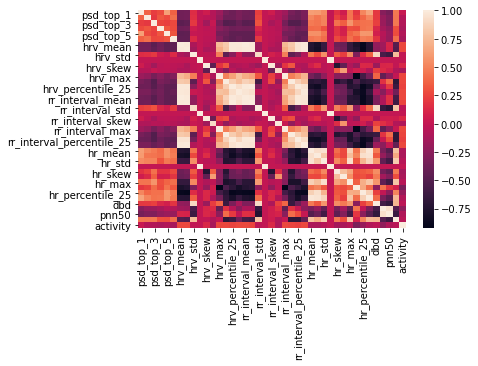

time: 404 ms


In [330]:
corr = data.corr()
sns.heatmap(data.corr())

In [331]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = data.columns[columns]
data = data[selected_columns]

time: 10.4 ms


In [332]:
data

,psd_top_1,psd_top_2,psd_top_3,psd_top_4,psd_top_5,psd_top_6,hrv_mean,hrv_std,hrv_trim_mean,hrv_skew,hrv_kurtosis,hrv_max,hrv_min,hr_mean,hr_skew,hr_kurtosis,hr_min,nn50,rmsd,activity
0,2.0,1.0,4.0,7.0,3.0,6.0,0.785819,0.048420,0.756667,0.035103,-1.046338,0.879144,0.682427,76.891826,0.203156,-0.838121,68.181818,11,0.0708,8.0
1,1.0,4.0,5.0,3.0,8.0,13.0,0.773468,0.054946,0.756667,-0.003509,-0.859602,0.880000,0.660098,78.522547,0.122091,-0.971539,68.181818,14,0.0652,8.0
2,2.0,3.0,1.0,6.0,5.0,4.0,0.657972,0.052525,0.756667,1.529374,2.825326,0.859992,0.580000,92.222056,-0.999364,2.060603,69.767442,26,0.0524,8.0
3,2.0,3.0,1.0,4.0,6.0,5.0,0.633523,0.052851,0.756667,1.963294,3.888746,0.858072,0.580000,95.776186,-1.731844,3.620456,69.767442,27,0.0600,8.0
4,2.0,4.0,5.0,1.0,8.0,3.0,0.646068,0.038107,0.756667,0.400976,-0.558382,0.739288,0.580000,93.634937,-0.210775,-0.700466,81.081081,23,0.0248,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,1.0,2.0,11.0,3.0,20.0,6.0,0.195123,0.084422,0.756667,0.757413,0.324443,0.484584,0.024235,657.917318,2.401294,4.522575,120.000000,8,2.7908,6.0
198,13.0,19.0,26.0,10.0,29.0,14.0,0.254875,0.103384,0.756667,0.433892,-0.807580,0.480000,0.067955,420.703999,4.272962,20.617344,120.000000,5,3.8216,6.0
199,13.0,6.0,1.0,11.0,42.0,26.0,0.207823,0.089930,0.756667,0.548548,-0.372023,0.459627,0.042322,573.829297,2.868120,7.984899,125.000000,5,3.4296,6.0
200,1.0,2.0,3.0,4.0,5.0,6.0,0.428489,0.044411,0.756667,0.307111,-1.177840,0.520000,0.360000,142.934600,-0.197930,-1.184953,115.384615,69,0.0128,6.0


time: 28 ms


In [333]:
X = data.drop(columns=['activity'])
y = data['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

time: 5.25 ms


## Classification

In [334]:
kf = KFold(5, random_state=42, shuffle=True)
accuracies = []
for train_idx, val_idx in kf.split(X_train, y_train):
    X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # A parameter grid for XGBoost
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'max_depth': [3, 4, 5],
            }

    model = XGBClassifier()
    clf = GridSearchCV(model, params, n_jobs=5, 
                   cv=StratifiedKFold(), 
                   verbose=0, refit=True)

    clf.fit(X_cur_train, y_cur_train)
    y_pred = clf.predict(X_val)
    top_features = list(map(lambda x: x[1], sorted(zip(clf.best_estimator_.feature_importances_, range(0,data.shape[1])), key=lambda x: x[0], reverse=True)))
    top_all_features = top_features
    accuracies.append(accuracy_score(y_pred, y_val))

print("CV score: {:.2f}".format(np.mean(accuracies)))

CV score: 0.30
time: 41.1 s


In [335]:
best = 0, None, 0
scores = []
for i in range(28, 10, -2):
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        model = XGBClassifier()
        clf = GridSearchCV(model, params, n_jobs=5, 
                       cv=StratifiedKFold(random_state=42, shuffle=True), 
                       verbose=0, refit=True)

        cur_top_features = top_features
        clf.fit(X_cur_train.iloc[:, cur_top_features[:i]], y_cur_train)
        y_pred = clf.predict(X_val.iloc[:, cur_top_features[:i]])
        top_features = list(map(lambda x: x[1], sorted(zip(clf.best_estimator_.feature_importances_, range(0,data.shape[1])), key=lambda x: x[0], reverse=True)))
        local_score = accuracy_score(y_pred, y_val)
        cv_scores.append(local_score)
        
    score = np.mean(cv_scores)
    scores.append(score)
    print("Score:", score)
    if score > best[0]:
         best = score, clf, cur_top_features[:i]

Score: 0.2797348484848485
Score: 0.29829545454545453
Score: 0.30454545454545456
Score: 0.28617424242424244
Score: 0.2922348484848485
Score: 0.29867424242424245
Score: 0.24242424242424243
Score: 0.2797348484848485
Score: 0.31079545454545454
time: 5min 43s


In [336]:
def show_result(y_pred, y_test):
    predicted = le.inverse_transform(y_pred.astype('int'))
    test = le.inverse_transform(y_test.astype('int'))
    sns.barplot(y='activity', x='correct', data=pd.DataFrame({
        'activity': test,
        'correct': predicted == test,
    }))

    return alt.Chart(pd.DataFrame({
        "predicted": predicted,
        "correct": test
    })).mark_bar().encode(
        x='count(predicted)',
        y='predicted:N',
    ).properties(
        width=170,
        height=180
    ).facet(facet='correct:N', columns=4)

time: 551 µs


Score: 0.31


alt.FacetChart(...)

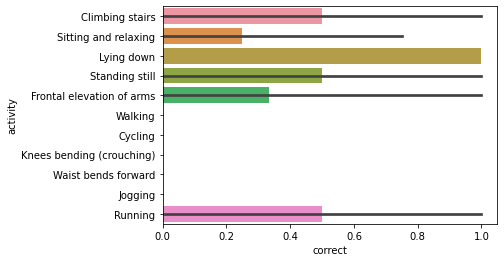

time: 431 ms


In [337]:
model = best[1].best_estimator_
y_pred = model.predict(X_test.iloc[:, best[2]])
print("Score: {:.2f}".format(best[0]))
show_result(y_pred, y_test)

Score: 0.37


alt.FacetChart(...)

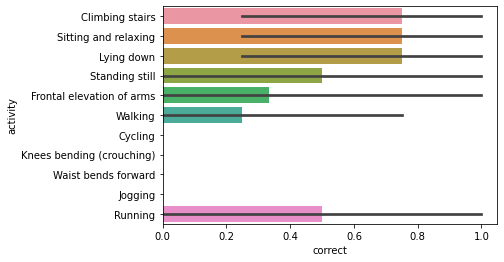

time: 43.5 s


In [338]:
params = {
            'C': np.arange(0.25, 14, 0.25),
            'kernel': ['poly', 'rbf', 'linear'],
            'degree': np.arange(1, 6, 1)
        }

model = SVC()
clf = GridSearchCV(model, params, n_jobs=5, 
               cv=StratifiedKFold(random_state=42, shuffle=True), 
               verbose=0, refit=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print("Score: {:.2f}".format(score))
show_result(y_pred, y_test)

Can see three groups of tasks:
- Running, Jogging
- Sitting and relaxing, Lying down, Standing still
- All others

## Accelerometer

In [312]:
def get_frequency_features(sig):
    f, Pxx_den = signal.periodogram(sig, fs)
    spectral_entropy = stats.entropy(Pxx_den)
    zero_crossing_rate = 1/window_length*np.nonzero(np.diff(sig > 0))[0].size
    energy = np.sum(Pxx_den)*(f[1]-f[0])
    return spectral_entropy, zero_crossing_rate, energy

def get_accelerometer_features(sig, accel_num=1):
    accel_names = [
        'acceleration, right-lower-arm (X axis)',
        'acceleration, right-lower-arm (Y axis)',
        'acceleration, right-lower-arm (Z axis)',
    ]
    features = [
        *get_sssp_features(sig[accel_names[accel_num]]), 
        *get_frequency_features(sig[accel_names[accel_num]])
    ]
    return features

time: 635 µs


In [250]:
accel_feature_names = [
    'accel_mean',
    'accel_median',
    'accel_std',
    'accel_trim_mean',
    'accel_skew',
    'accel_kurtosis',
    'accel_max',
    'accel_min',
    'accel_percentile_25',
    'accel_percentile_75',
    'spectral_entropy',
    'zero_crossing_rate',
    'energy'
]

time: 432 µs


In [253]:
data = []
for signals, activity in signal_activity_pairs:
    data.append(get_accelerometer_features(signals, accel_num=0) +
                get_accelerometer_features(signals, accel_num=1) +
                get_accelerometer_features(signals, accel_num=2) +
                [activity]
               )
    
data = pd.DataFrame(data=data, columns=append_suffix(accel_feature_names, "_x") + \
                                                     append_suffix(accel_feature_names, "_y") + \
                                                     append_suffix(accel_feature_names, "_z") + ['activity'])

time: 1.03 s


In [254]:
data

,accel_mean_x,accel_median_x,accel_std_x,accel_trim_mean_x,accel_skew_x,accel_kurtosis_x,accel_max_x,accel_min_x,accel_percentile_25_x,accel_percentile_75_x,...,accel_skew_z,accel_kurtosis_z,accel_max_z,accel_min_z,accel_percentile_25_z,accel_percentile_75_z,spectral_entropy_z,zero_crossing_rate_z,energy_z,activity
0,-2.997685,-2.99800,0.140972,0.756667,-0.015850,0.025132,-2.560200,-3.4788,-3.089650,-2.900900,...,-0.023294,-0.003399,2.0668,1.18150,1.592775,1.753700,5.622283,0.000000,0.013768,Standing still
1,-3.117459,-3.11730,0.119482,0.756667,0.057943,0.398851,-2.669700,-3.5723,-3.198325,-3.042625,...,-0.038977,0.525451,2.0942,1.24850,1.572500,1.714150,6.130232,0.000000,0.011321,Standing still
2,-3.124153,-3.12505,0.114692,0.756667,0.115003,-0.019590,-2.747200,-3.5375,-3.205700,-3.045650,...,-0.066754,0.075328,2.5464,1.72740,2.020600,2.177600,5.767899,0.000000,0.014276,Standing still
3,-3.130699,-3.13460,0.112362,0.756667,0.074785,-0.007037,-2.759500,-3.5333,-3.206525,-3.052600,...,-0.243532,0.146659,2.3215,1.55420,1.900100,2.048200,6.075781,0.000000,0.012356,Standing still
4,-2.298497,-2.29440,0.261011,0.756667,-0.439832,16.243178,-0.055252,-4.8764,-2.424550,-2.160400,...,-0.555730,4.476822,2.1626,-0.27622,0.945475,1.189425,5.434793,0.133333,0.042548,Standing still
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,-8.841738,-7.43595,10.268171,0.756667,-0.011436,-1.559635,11.507000,-21.5840,-20.995000,0.490905,...,-0.515819,0.447047,9.0247,-17.67800,-6.005450,-0.469735,4.022206,5.566667,23.574048,Running
198,-7.668179,-5.93610,11.498606,0.756667,0.159178,-1.284088,17.404000,-21.7220,-20.997250,0.977980,...,-0.156852,-0.276829,16.1910,-17.67400,-5.367250,2.019225,3.611271,6.033333,21.344201,Running
199,-8.392084,-8.34460,11.361841,0.756667,0.323112,-1.143919,18.956000,-21.5900,-20.927250,0.239838,...,-0.286713,-0.495338,9.3535,-18.21600,-6.806100,0.896680,3.540184,5.133333,23.508092,Running
200,-7.357355,-7.26380,11.707073,0.756667,0.361139,-0.967559,19.398000,-21.7810,-20.888500,0.076436,...,0.608753,0.356331,19.4490,-12.31800,-3.043225,3.337475,3.605294,4.766667,20.748947,Running


time: 30.2 ms


In [255]:
le = LabelEncoder()
data.iloc[:, -1] = le.fit_transform(data.iloc[:,-1]).astype('float64')

time: 1.99 ms


<AxesSubplot:>

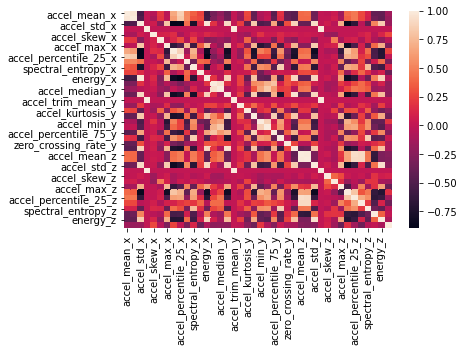

time: 388 ms


In [256]:
corr = data.corr()
sns.heatmap(data.corr())

In [257]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = data.columns[columns]
data = data[selected_columns]

time: 30.1 ms


In [258]:
data

,accel_mean_x,accel_std_x,accel_trim_mean_x,accel_skew_x,accel_kurtosis_x,accel_max_x,accel_min_x,accel_percentile_25_x,accel_percentile_75_x,spectral_entropy_x,...,spectral_entropy_y,zero_crossing_rate_y,accel_mean_z,accel_skew_z,accel_kurtosis_z,accel_max_z,accel_min_z,spectral_entropy_z,zero_crossing_rate_z,activity
0,-2.997685,0.140972,0.756667,-0.015850,0.025132,-2.560200,-3.4788,-3.089650,-2.900900,5.114790,...,6.099430,0.000000,1.672334,-0.023294,-0.003399,2.0668,1.18150,5.622283,0.000000,8.0
1,-3.117459,0.119482,0.756667,0.057943,0.398851,-2.669700,-3.5723,-3.198325,-3.042625,5.992271,...,6.173418,0.000000,1.642702,-0.038977,0.525451,2.0942,1.24850,6.130232,0.000000,8.0
2,-3.124153,0.114692,0.756667,0.115003,-0.019590,-2.747200,-3.5375,-3.205700,-3.045650,6.014151,...,6.199440,0.000000,2.100157,-0.066754,0.075328,2.5464,1.72740,5.767899,0.000000,8.0
3,-3.130699,0.112362,0.756667,0.074785,-0.007037,-2.759500,-3.5333,-3.206525,-3.052600,5.959254,...,6.217004,0.000000,1.970681,-0.243532,0.146659,2.3215,1.55420,6.075781,0.000000,8.0
4,-2.298497,0.261011,0.756667,-0.439832,16.243178,-0.055252,-4.8764,-2.424550,-2.160400,5.626610,...,5.978095,0.000000,1.062500,-0.555730,4.476822,2.1626,-0.27622,5.434793,0.133333,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,-8.841738,10.268171,0.756667,-0.011436,-1.559635,11.507000,-21.5840,-20.995000,0.490905,2.248070,...,2.253113,2.900000,-3.513888,-0.515819,0.447047,9.0247,-17.67800,4.022206,5.566667,6.0
198,-7.668179,11.498606,0.756667,0.159178,-1.284088,17.404000,-21.7220,-20.997250,0.977980,2.258945,...,1.862212,3.000000,-1.574815,-0.156852,-0.276829,16.1910,-17.67400,3.611271,6.033333,6.0
199,-8.392084,11.361841,0.756667,0.323112,-1.143919,18.956000,-21.5900,-20.927250,0.239838,1.483659,...,2.451270,3.100000,-3.036431,-0.286713,-0.495338,9.3535,-18.21600,3.540184,5.133333,6.0
200,-7.357355,11.707073,0.756667,0.361139,-0.967559,19.398000,-21.7810,-20.888500,0.076436,2.414927,...,1.870318,2.866667,0.675381,0.608753,0.356331,19.4490,-12.31800,3.605294,4.766667,6.0


time: 64.7 ms


In [259]:
X = data.drop(columns=['activity'])
y = data['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

time: 6.83 ms


In [317]:
kf = KFold(5, random_state=42, shuffle=True)
accuracies = []
for train_idx, val_idx in kf.split(X_train, y_train):
    X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # A parameter grid for XGBoost
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'max_depth': [3, 4, 5],
            }

    model = XGBClassifier()
    clf = GridSearchCV(model, params, n_jobs=5, 
                   cv=StratifiedKFold(), 
                   verbose=0, refit=True)

    clf.fit(X_cur_train, y_cur_train)
    y_pred = clf.predict(X_val)
    top_features = list(map(lambda x: x[1], sorted(zip(clf.best_estimator_.feature_importances_, range(0,data.shape[1])), key=lambda x: x[0], reverse=True)))
    top_all_features = top_features
    accuracies.append(accuracy_score(y_pred, y_val))

print("CV score: {:.2f}".format(np.mean(accuracies)))

CV score: 0.78
time: 37.6 s


In [318]:
best = 0, None, 0
scores = []
for i in range(28, 10, -2):
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_cur_train, y_cur_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        model = XGBClassifier()
        clf = GridSearchCV(model, params, n_jobs=5, 
                       cv=StratifiedKFold(random_state=42, shuffle=True), 
                       verbose=0, refit=True)

        cur_top_features = top_features
        clf.fit(X_cur_train.iloc[:, cur_top_features[:i]], y_cur_train)
        y_pred = clf.predict(X_val.iloc[:, cur_top_features[:i]])
        top_features = list(map(lambda x: x[1], sorted(zip(clf.best_estimator_.feature_importances_, range(0,data.shape[1])), key=lambda x: x[0], reverse=True)))
        local_score = accuracy_score(y_pred, y_val)
        cv_scores.append(local_score)
        
    score = np.mean(cv_scores)
    scores.append(score)
    print("Score:", score)
    if score > best[0]:
         best = score, clf, cur_top_features[:i]

Score: 0.8073863636363636
Score: 0.7946969696969697
Score: 0.7950757575757577
Score: 0.7640151515151515
Score: 0.7825757575757576
Score: 0.7825757575757576
Score: 0.7823863636363637
Score: 0.7765151515151516
Score: 0.7450757575757576
time: 5min 35s


Score: 0.81


alt.FacetChart(...)

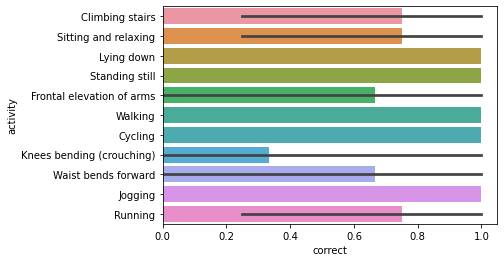

time: 444 ms


In [319]:
model = best[1].best_estimator_
y_pred = model.predict(X_test.iloc[:, best[2]])
print("Score: {:.2f}".format(best[0]))
show_result(y_pred, y_test)

Score: 0.80


alt.FacetChart(...)

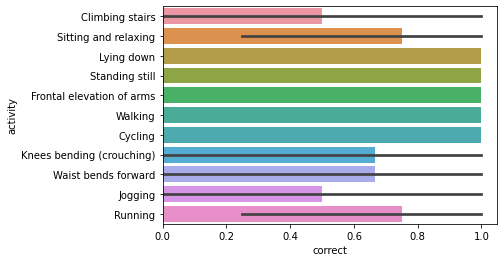

time: 7.61 s


In [325]:
params = {
            'C': np.arange(0.25, 14, 0.25),
            'kernel': ['poly', 'rbf', 'linear'],
            'degree': np.arange(1, 6, 1)
        }

model = SVC()
clf = GridSearchCV(model, params, n_jobs=5, 
               cv=StratifiedKFold(random_state=42, shuffle=True), 
               verbose=0, refit=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print("Score: {:.2f}".format(score))
show_result(y_pred, y_test)

Бачимо, що на даний момент є всього 2 проблеми:
- Jogging vs Running (проте все одно досить хороша точність, адже при бігові руки більше рухаються і може бути наслідком того, що легкий біг для одного є сильним для іншого)
- Climbing stairs, Knees bending, waist bends forward vs walking (як дії з малими рухами руками)